Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

%matplotlib inline

First reload the data we generated in `1_notmnist.ipynb`.

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [5]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [6]:
def initialize_parameters(layers_dims):
    parameters = {}    
    for l in range(1, len(layers_dims)):
        parameters['W' + str(l)] = tf.Variable(tf.truncated_normal([layers_dims[l-1], layers_dims[l]]))
        parameters['b' + str(l)] = tf.Variable(tf.zeros([layers_dims[l]]))
    return parameters

def forward_propagation(X, parameters):
    A = X
    L = len(parameters) // 2 + 1 # number of layers in the neural network
    # linear[1] -> relu -> liner[2] -> ... -> relu -> linear[L-1]
    for l in range(1, L):
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        Z = tf.add(tf.matmul(A, W), b)
        if (l < L - 1):
            A = tf.nn.relu(Z)
    return Z

def loss_l2(lambd):
    variables = tf.trainable_variables()
    lossl2 = tf.add_n([tf.nn.l2_loss(i) for i in variables]) * lambd
    return lossl2

In [16]:
def batch_model(layers = None, num_iterations = 3001, batch_size = 128, learning_rate= 0.5, lambd = 0.002, trace = True):
    costs = []
    
    graph = tf.Graph()
    with graph.as_default():

        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size**2))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset) 

        if (not layers):
            layers = [ image_size**2, num_labels ]

        parameters = initialize_parameters(layers)

        logits = forward_propagation(tf_train_dataset, parameters)

        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + loss_l2(lambd)

        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

        train_prediction = tf.nn.softmax(forward_propagation(tf_train_dataset, parameters))
        valid_prediction = tf.nn.softmax(forward_propagation(tf_valid_dataset, parameters))
        test_prediction = tf.nn.softmax(forward_propagation(tf_test_dataset, parameters))
    
    with tf.Session(graph=graph) as session:
    
        tf.global_variables_initializer().run()

        for step in range(num_iterations):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {
                tf_train_dataset : batch_data, 
                tf_train_labels : batch_labels
            }
            _, step_cost, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (trace and step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, step_cost))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
                print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
            if (step % 5 == 0):
                costs.append(step_cost)

        accuracy_batch = accuracy(predictions, batch_labels)
        accuracy_dev = accuracy(valid_prediction.eval(), valid_labels)
        accuracy_test = accuracy(test_prediction.eval(), test_labels)

    return costs, accuracy_batch, accuracy_dev, accuracy_test

In [17]:
costs, accuracy_batch, accuracy_dev, accuracy_test = batch_model()

Minibatch loss at step 0: 22.687983
Minibatch accuracy: 10.9%
Validation accuracy: 11.3%
Test accuracy: 11.1%
Minibatch loss at step 500: 2.877911
Minibatch accuracy: 80.5%
Validation accuracy: 76.8%
Test accuracy: 84.5%
Minibatch loss at step 1000: 1.263011
Minibatch accuracy: 82.8%
Validation accuracy: 80.2%
Test accuracy: 87.5%
Minibatch loss at step 1500: 0.710608
Minibatch accuracy: 87.5%
Validation accuracy: 81.0%
Test accuracy: 88.0%
Minibatch loss at step 2000: 0.689865
Minibatch accuracy: 83.6%
Validation accuracy: 81.1%
Test accuracy: 87.8%
Minibatch loss at step 2500: 0.869454
Minibatch accuracy: 79.7%
Validation accuracy: 78.8%
Test accuracy: 85.2%
Minibatch loss at step 3000: 0.885673
Minibatch accuracy: 78.1%
Validation accuracy: 80.5%
Test accuracy: 87.7%


In [18]:
layers = [ image_size**2, 1024, num_labels ]
costs, accuracy_batch, accuracy_dev, accuracy_test = batch_model(layers)

Minibatch loss at step 0: 1003.704468
Minibatch accuracy: 8.6%
Validation accuracy: 19.9%
Test accuracy: 22.2%
Minibatch loss at step 500: 239.000839
Minibatch accuracy: 84.4%
Validation accuracy: 78.7%
Test accuracy: 85.9%
Minibatch loss at step 1000: 83.849747
Minibatch accuracy: 82.0%
Validation accuracy: 83.1%
Test accuracy: 90.1%
Minibatch loss at step 1500: 31.322704
Minibatch accuracy: 81.2%
Validation accuracy: 83.8%
Test accuracy: 90.4%
Minibatch loss at step 2000: 11.535193
Minibatch accuracy: 90.6%
Validation accuracy: 86.3%
Test accuracy: 92.8%
Minibatch loss at step 2500: 4.672983
Minibatch accuracy: 83.6%
Validation accuracy: 86.5%
Test accuracy: 93.2%
Minibatch loss at step 3000: 2.109152
Minibatch accuracy: 85.2%
Validation accuracy: 86.8%
Test accuracy: 93.1%


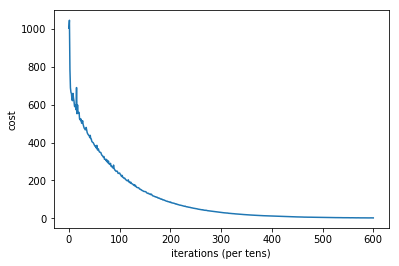

In [19]:
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [20]:
train_subset = 1024
train_dataset_temp = train_dataset
train_dataset = train_dataset[:train_subset, :]
train_labels_temp = train_labels
train_labels = train_labels[:train_subset, :]

In [21]:
layers = [ image_size**2, 1024, num_labels ]
costs, accuracy_batch, accuracy_dev, accuracy_test = batch_model(layers)

Minibatch loss at step 0: 1043.533325
Minibatch accuracy: 7.8%
Validation accuracy: 27.9%
Test accuracy: 30.3%
Minibatch loss at step 500: 230.401978
Minibatch accuracy: 100.0%
Validation accuracy: 77.3%
Test accuracy: 84.8%
Minibatch loss at step 1000: 84.775749
Minibatch accuracy: 99.2%
Validation accuracy: 75.5%
Test accuracy: 82.3%
Minibatch loss at step 1500: 31.141104
Minibatch accuracy: 100.0%
Validation accuracy: 77.3%
Test accuracy: 84.9%
Minibatch loss at step 2000: 11.465149
Minibatch accuracy: 100.0%
Validation accuracy: 78.7%
Test accuracy: 86.2%
Minibatch loss at step 2500: 4.282235
Minibatch accuracy: 99.2%
Validation accuracy: 80.2%
Test accuracy: 87.4%
Minibatch loss at step 3000: 1.630759
Minibatch accuracy: 100.0%
Validation accuracy: 80.8%
Test accuracy: 87.8%


In [22]:
train_dataset = train_dataset_temp
del train_dataset_temp
train_labels = train_labels_temp
del train_labels_temp

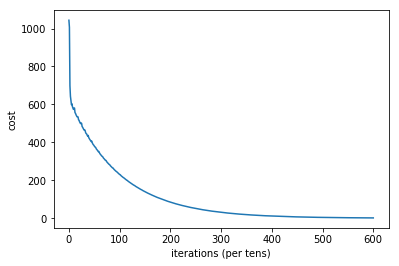

In [23]:
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.show()

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---
